In [4]:
import os
import random
import logging
import time

import cv2
import albumentations as A
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
from torchvision import transforms
from tqdm import tqdm

In [5]:
# randomness 제어를 위한 시드 고정 (학습 결과 재현을 위해 고정)
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache()


# 시드 값 선택
SEED = 42
set_seed(SEED)

# 학습 장치 결정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
isPc = 2;
#kaggle하고 왔다갔다 하면서 하다보니 계속 바꾸는게 귀찮아서 플래그 하나 추가.

In [7]:
# 경로 설정 (로컬 환경인 경우 자신의 경로로 설정)
# Administrator 계정이라 접근 권한 문제때문에 절대경로로 입력했습니다.
# 이번 프로젝트 끝나면 포멧하고 PC 다시 구축 예정...
if isPc == 1 :
    root_dir = 'C:/Users/Administrator/Documents/Education/DeepLearning/FinalProject/'
    save_dir = 'C:/Users/Administrator/Documents/Education/DeepLearning/FinalProject/save/'
    
    train_dir = 'C:/Users/Administrator/Documents/Education/DeepLearning/FinalProject/train/'
    train_w2v_dir = 'C:/Users/Administrator/Documents/Education/DeepLearning/FinalProject/train_w2v/'
    test_dir = 'C:/Users/Administrator/Documents/Education/DeepLearning/FinalProject/test/'
    test_w2v_dir = 'C:/Users/Administrator/Documents/Education/DeepLearning/FinalProject/test_w2v/'
    
    train_df = pd.read_csv('C:/Users/Administrator/Documents/Education/DeepLearning/FinalProject/train.csv')
    test_df = pd.read_csv('C:/Users/Administrator/Documents/Education/DeepLearning/FinalProject/test.csv')

    train_df['path'] = train_df['path'].apply(lambda x: train_dir + x.split('/')[-1])
    test_df['path'] = test_df['path'].apply(lambda x: test_dir + x.split('/')[-1])
    train_df['w2v_path'] = train_df['w2v_path'].apply(lambda x: train_w2v_dir + x.split('/')[-1])
    test_df['w2v_path'] = test_df['w2v_path'].apply(lambda x: test_w2v_dir + x.split('/')[-1])
    
elif isPc == 2 : 
    root_dir = 'C:/Users/mmc/Documents/jupyter/DeepLearning/FinalProject/'
    save_dir = 'C:/Users/mmc/Documents/jupyter/DeepLearning/FinalProject/save/'

    train_dir = 'C:/Users/mmc/Documents/jupyter/DeepLearning/FinalProject//train/'
    train_w2v_dir = 'C:/Users/mmc/Documents/jupyter/DeepLearning/FinalProject//train_w2v/'
    test_dir = 'C:/Users/mmc/Documents/jupyter/DeepLearning/FinalProject//test/'
    test_w2v_dir = 'C:/Users/mmc/Documents/jupyter/DeepLearning/FinalProject//test_w2v/'
    
    train_df = pd.read_csv('C:/Users/mmc/Documents/jupyter/DeepLearning/FinalProject/train.csv')
    test_df = pd.read_csv('C:/Users/mmc/Documents/jupyter/DeepLearning/FinalProject/test.csv')

    train_df['path'] = train_df['path'].apply(lambda x: train_dir + x.split('/')[-1])
    test_df['path'] = test_df['path'].apply(lambda x: test_dir + x.split('/')[-1])
    train_df['w2v_path'] = train_df['w2v_path'].apply(lambda x: train_w2v_dir + x.split('/')[-1])
    test_df['w2v_path'] = test_df['w2v_path'].apply(lambda x: test_w2v_dir + x.split('/')[-1])
    
else :
    root_dir = '/kaggle/input/2024-dl-final/'
    save_dir = '/kaggle/working/'

    train_dir = root_dir + 'train/'
    train_w2v_dir = root_dir + 'train_w2v/'
    test_dir = root_dir + 'test/'
    test_w2v_dir = root_dir + 'test_w2v/'
    
    train_df = pd.read_csv(root_dir + 'train.csv')
    test_df = pd.read_csv(root_dir + 'test.csv')



In [8]:
# str -> list 변환 ("['Romance', 'Action', ...]" -> ['Romance', 'Action', ...])
train_df['genres'] = train_df['genres'].apply(lambda x: eval(x))

# multi label encoding
mlb = MultiLabelBinarizer()
train_label = mlb.fit_transform(train_df['genres'])

# column 순서 확인
#mlb.classes_

# 기존 데이터와 결합
mlb_train = pd.DataFrame(train_label, columns=mlb.classes_)

train_df = pd.concat([train_df, mlb_train], axis=1)
train_df.head()

,id,path,w2v_path,title,year,genres,Action,Animation,Comedy,Documentary,Drama,Horror,Romance,Thriller
0,13,C:/Users/mmc/Documents/jupyter/DeepLearning/Fi...,C:/Users/mmc/Documents/jupyter/DeepLearning/Fi...,Forrest Gump,1994,"[Comedy, Drama, Romance]",0,0,1,0,1,0,1,0
1,55,C:/Users/mmc/Documents/jupyter/DeepLearning/Fi...,C:/Users/mmc/Documents/jupyter/DeepLearning/Fi...,Amores Perros,2000,"[Drama, Thriller]",0,0,0,0,1,0,0,1
2,64,C:/Users/mmc/Documents/jupyter/DeepLearning/Fi...,C:/Users/mmc/Documents/jupyter/DeepLearning/Fi...,Talk to Her,2002,"[Drama, Romance]",0,0,0,0,1,0,1,0
3,80,C:/Users/mmc/Documents/jupyter/DeepLearning/Fi...,C:/Users/mmc/Documents/jupyter/DeepLearning/Fi...,Before Sunset,2004,"[Drama, Romance]",0,0,0,0,1,0,1,0
4,86,C:/Users/mmc/Documents/jupyter/DeepLearning/Fi...,C:/Users/mmc/Documents/jupyter/DeepLearning/Fi...,The Elementary Particles,2006,"[Drama, Romance]",0,0,0,0,1,0,1,0


In [9]:
#transform Image
#
train_transform = A.Compose([
    #A.Rotate(limit=180),  # RandomRotation 대체
    #A.RandomResizedCrop(height=128, width=128, scale=(0.6, 1.0)),  # RandomResizedCrop 대체
    #A.HorizontalFlip(p=0.5),  # RandomHorizontalFlip 대체
    A.Normalize(),  # Normalize
    ToTensorV2()  # ToTensor 대체
])

test_transform = A.Compose([
    #A.Resize(128, 128),  # Resize 대체
    #A.CenterCrop(128, 128),  # CenterCrop 대체
    A.Normalize(),
    ToTensorV2()
])

In [10]:
class MovieDataset(Dataset):
    def __init__(self, df, transform=None, mode='train'):
        self.df = df
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.df.iloc[idx, 1]), cv2.COLOR_BGR2RGB)
        w2v = torch.Tensor(np.load(self.df.iloc[idx, 2]))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            image = A.ToTensorV2()(image=image)

        if self.mode == 'train':
            label = torch.Tensor(self.df.iloc[idx, 6:].to_numpy(dtype=np.float32))
            return image, w2v, label

        return image, w2v

In [11]:
batch_size = 256
#batch_size = 32
num_workers = 0  # kaggle에서 학습하는 경우 최대 2까지 설정

# train/validation 분리
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=SEED,
                                    stratify=train_df['genres'])

train_dataset = MovieDataset(df=train_df, transform=train_transform)
val_dataset = MovieDataset(df=val_df, transform=test_transform)
test_dataset = MovieDataset(df=test_df, transform=test_transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

train_dataset.__len__(), val_dataset.__len__(), test_dataset.__len__()

(12080, 3021, 5034)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.552854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.639

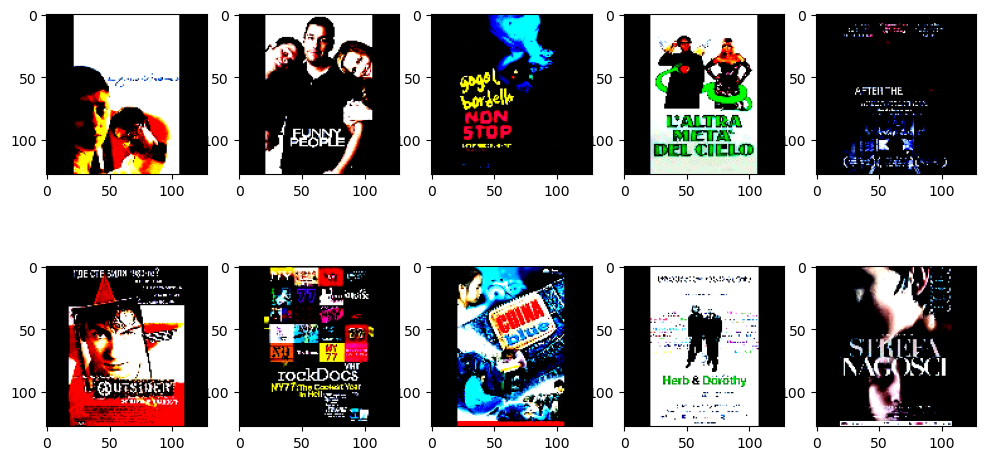

In [20]:
imgs = []
for i in range(10):
    img, _, _ = train_dataset.__getitem__(i)  # transform이 적용된 이미지 반환
    img = img.permute((1, 2, 0)).float()
    imgs.append(img.numpy())  # (3, 128, 128) 형태의 image를 (128, 128, 3) 형태로 바꿔서 저장

fig = plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])

plt.show()

In [22]:
class MovieClassifier(nn.Module):
    def __init__(self, num_classes, hidden_size):
        super(MovieClassifier, self).__init__()
        self.num_classes = num_classes
        self.hidden_size = hidden_size

        self.cnn = nn.Sequential(
            nn.Conv2d(3 , 96 , (8,8), stride=2, padding = 0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.AvgPool2d(3, stride = 2),

            nn.Conv2d(96 , 256 , (5,5), stride=1, padding = 2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.AvgPool2d(3, stride = 2),
            
            nn.Conv2d(256 , 384 , (3, 3), stride=1, padding = 1),
            nn.ReLU(),

            nn.Conv2d(384 , 384 , (4, 4), stride=1, padding = 1),
            nn.ReLU(),

            nn.Conv2d(384 , 256 , (3, 3), stride=1, padding = 1),
            nn.ReLU(),
            
            nn.MaxPool2d(3, stride = 2),
            nn.Dropout(0.5),
        )
        
        self.fc = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(256 * 6 * 6 + hidden_size * 2, hidden_size),
            nn.ReLU(),
            
            nn.Linear(hidden_size, hidden_size*2),
            nn.ReLU(),
            
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU(),

            nn.Linear(hidden_size, num_classes),
        )

        # ##### lstm을 사용하는 경우 #####
        self.lstm = nn.LSTM(300, self.hidden_size, bidirectional=True, batch_first=True)

    def forward(self, x, x2):
        #CNN
        x = self.cnn(x)
        x = x.view(x.size(0), -1)

        #LSTM Path
        x2, _ = self.lstm(x2)
        x2 = x2.mean(dim=1)

        x = torch.cat((x, x2), dim=1)

        #FC
        x = self.fc(x)
        return x

In [28]:
num_classes = mlb.classes_.shape[0]

model = MovieClassifier(num_classes,128).to(device) #num_classes로 

#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001) #Optimizer로 우선 Adam 사용

train_losses, val_losses, = [], []
epochs = 20
threshold = 0.25

In [29]:
for epoch in range(epochs):
    print("Starting Epoch " + str(epoch))
    running_loss = 0.0
    test_loss = 0.0
    accuracy = 0.0

    model.train()


    for inputs, w2v, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        inputs, w2v, labels = (
            inputs.float().to(device),
            w2v.float().to(device),
            labels.float().to(device)
        )
        
        optimizer.zero_grad()

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs, w2v)
            loss = criterion(outputs, labels)
            
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    model.eval()

    with torch.no_grad():
        for inputs, w2v, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            inputs, w2v, labels = (
                inputs.float().to(device),
                w2v.float().to(device),
                labels.float().to(device)
            )

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs, w2v)
                loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
            
            predicted = outputs.sigmoid()
            predicted = (predicted > threshold).long()
            accuracy += (predicted == labels).float().mean().item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(test_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(train_loader):.3f}.. "
          f"Validation loss: {test_loss/len(val_loader):.3f}.. "
          f"Validation accuracy: {accuracy/len(val_loader):.3f}")

Starting Epoch 0


Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch 1/20.. Train loss: 0.534.. Validation loss: 0.450.. Validation accuracy: 0.737
Starting Epoch 1


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.36it/s]


Epoch 2/20.. Train loss: 0.449.. Validation loss: 0.449.. Validation accuracy: 0.737
Starting Epoch 2


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 3/20.. Train loss: 0.448.. Validation loss: 0.450.. Validation accuracy: 0.737
Starting Epoch 3


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


Epoch 4/20.. Train loss: 0.441.. Validation loss: 0.425.. Validation accuracy: 0.741
Starting Epoch 4


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 5/20.. Train loss: 0.421.. Validation loss: 0.421.. Validation accuracy: 0.741
Starting Epoch 5


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.19it/s]


Epoch 6/20.. Train loss: 0.415.. Validation loss: 0.420.. Validation accuracy: 0.747
Starting Epoch 6


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 7/20.. Train loss: 0.413.. Validation loss: 0.416.. Validation accuracy: 0.744
Starting Epoch 7


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.01it/s]


Epoch 8/20.. Train loss: 0.411.. Validation loss: 0.416.. Validation accuracy: 0.753
Starting Epoch 8


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.17it/s]


Epoch 9/20.. Train loss: 0.407.. Validation loss: 0.417.. Validation accuracy: 0.739
Starting Epoch 9


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


Epoch 10/20.. Train loss: 0.405.. Validation loss: 0.415.. Validation accuracy: 0.739
Starting Epoch 10


Validation Epoch 11: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


Epoch 11/20.. Train loss: 0.405.. Validation loss: 0.417.. Validation accuracy: 0.744
Starting Epoch 11


Validation Epoch 12: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.15it/s]


Epoch 12/20.. Train loss: 0.402.. Validation loss: 0.416.. Validation accuracy: 0.733
Starting Epoch 12


Validation Epoch 13: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


Epoch 13/20.. Train loss: 0.400.. Validation loss: 0.415.. Validation accuracy: 0.735
Starting Epoch 13


Validation Epoch 14: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.21it/s]


Epoch 14/20.. Train loss: 0.397.. Validation loss: 0.414.. Validation accuracy: 0.749
Starting Epoch 14


Validation Epoch 15: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.17it/s]


Epoch 15/20.. Train loss: 0.395.. Validation loss: 0.414.. Validation accuracy: 0.732
Starting Epoch 15


Validation Epoch 16: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.99it/s]


Epoch 16/20.. Train loss: 0.392.. Validation loss: 0.419.. Validation accuracy: 0.753
Starting Epoch 16


Validation Epoch 17: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.16it/s]


Epoch 17/20.. Train loss: 0.390.. Validation loss: 0.415.. Validation accuracy: 0.755
Starting Epoch 17


Validation Epoch 18: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


Epoch 18/20.. Train loss: 0.387.. Validation loss: 0.415.. Validation accuracy: 0.746
Starting Epoch 18


Validation Epoch 19: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.15it/s]


Epoch 19/20.. Train loss: 0.386.. Validation loss: 0.416.. Validation accuracy: 0.736
Starting Epoch 19


Validation Epoch 20: 100%|█████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]

Epoch 20/20.. Train loss: 0.386.. Validation loss: 0.415.. Validation accuracy: 0.735


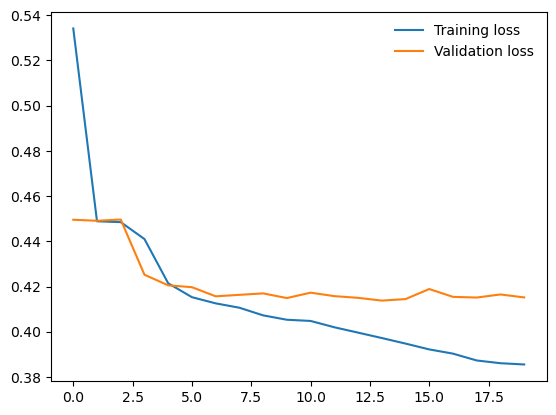

In [32]:
plt.plot(train_losses[0:20], label='Training loss')
plt.plot(val_losses[0:20], label='Validation loss')
plt.legend(frameon=False)

In [34]:
def test(model, test_loader, threshold=0.25):
    outputs = []

    model.eval()
    with torch.no_grad():
        for image, w2v in tqdm(test_loader, desc='Test'):
            image, w2v = image.float().to(device), w2v.float().to(device)

            # Automatic Mixed Precision(AMP) 사용 (학습 속도, 메모리 절약)
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                output = model(image, w2v)

            output = output.detach().sigmoid()
            output = (output > threshold).long()  # threshold를 기준으로 0/1 판별
            outputs.append(output)

    outputs = torch.cat(outputs, dim=0).cpu().numpy()

    return outputs

In [36]:
from datetime import datetime

dt = datetime.now()
ctime = dt.strftime('%m%d_%H%M')  # 현재 월/일_시/분 확인

#model = torch.load(save_dir, weights_only=False)  # save_dir + [file_name]
model = model.to(device)

threshold = 0.25
results = test(model, test_loader, threshold=threshold)

submission = pd.read_csv(root_dir + 'sample_submission.csv')
submission.iloc[:, 1:] = results
submission.to_csv(save_dir + f'submission_{ctime}.csv', index=False)

Test: 100%|████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.35s/it]


Precision score : 0.39112602535421326
Recall score : 0.6741645244215938
F-score : 0.49504483246814524


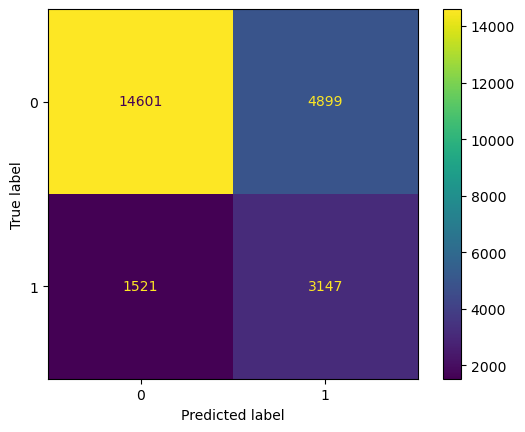

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

outputs = []
v_loss = 0
tp, tn, fp, fn = 0, 0, 0, 0

model.eval()
with torch.no_grad():
    for image, w2v, label in val_loader:
        image, w2v, label = image.float().to(device), w2v.float().to(device), label.float().to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            output = model(image, w2v)
            loss = criterion(output, label)

        output = output.detach().sigmoid()
        output = (output > threshold).long()
        label, output = label.cpu(), output.cpu()

        mcm = multilabel_confusion_matrix(label, output, samplewise=True)
        outputs.append(mcm)

        v_loss += loss.cpu().item()

        # tp += ((label == 1) & (output == 1)).float().sum()
        # tn += ((label == 0) & (output == 0)).float().sum()
        # fp += ((label == 0) & (label != output)).float().sum()
        # fn += ((label == 1) & (label != output)).float().sum()

# 1. tp, tn, fp, fn을 직접 구하는 방법 
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
# f1 = 2 * (precision * recall) / (precision + recall)

# 2. confusion matrix의 결과를 바로 사용하는 방법 (tn, fp, fn, tp)
# cm = [[tn, fp],
#       [fn, tp]]

conf = np.sum(np.concatenate(outputs), axis=0)
precision = conf[1, 1] / (conf[1, 1] + conf[0, 1])
recall = conf[1, 1] / (conf[1, 1] + conf[1, 0])
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Precision score : {precision}')
print(f'Recall score : {recall}')
print(f'F-score : {f1}')

disp = ConfusionMatrixDisplay(conf)
disp.plot()
plt.show()